## RNN 구조


<img src="https://github.com/LeeHyeJin91/PapersWithCode/assets/43728746/b5eb542e-deef-4449-a6ec-dfd158f65c6a" width="500" height="500"/>


## RNN 계산그래프

<img src="https://github.com/LeeHyeJin91/PapersWithCode/assets/43728746/151a0cbf-7087-4562-88c0-5e837537c265" width="900" height="500"/>


#### Embedding class

In [1]:
import numpy as np

In [2]:
class EmbeddingLayer:
    
    def __init__(self, W):
        self.params = [W] # (V, D)
        self.grads = [np.zeros_like(W)]
        self.idx = None
     
    def forward(self, x):
        # input: x (N, 1)
        
        W, = self.params
        self.idx = x
        
        return W[x] # (N, D)
        
    def backward(self, dx):
        # input: dx (N, D)
        
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dx) # dW self.idx 행에 dx더함 -> self.grads도 같이 바뀜
        
        return None
    
class Embedding:
    
    def __init__(self, W):
        
        self.params = [W] # (V, D)
        self.grads = [np.zeros_like(W)]
        self.W = W
        self.layers = []
        
    def forward(self, input_x):
        # input:  input_x  (N, T)
        # output: x        (N, T, D)
        
        N, T = input_x.shape
        V, D = self.W.shape
        
        x = np.empty((N, T, D), dtype='f')
        for t in range(T):
            layer = EmbeddingLayer(self.W)
            x[:, t, :] = layer.forward(input_x[:, t]) # (N, D)
            self.layers.append(layer)
        
        return x
        
    def backward(self, dx):
        # input dx: (N, T, D)
        
        N, T, D = dx.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dx[:, t, :])
            grad += layer.grads[0]    # (V, D)
        
        self.grads[0][...] = grad
         
        return None
    

#### Rnn class

In [3]:
class RnnLayer:
    
    def __init__(self, Wh, Wx, b):
        
        self.params = [Wh, Wx, b]
        self.grads = [np.zeros_like(Wh), np.zeros_like(Wx), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        # input:  x (N, D), h_prev (N, H)
        # output: h_next (N, H)
        
        Wh, Wx, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        
        return h_next
        
    def backward(self, dh_next):
        # input:  dh_next (N, H)
        # output: dx (N, D) dh_prev (N, H)
        
        Wh, Wx, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2) # (N, H)
        db = np.sum(dt, axis=0)        # (H, )
        
        dWh = np.matmul(h_prev.T, dt)  # (H, N) (N, H)
        dh_prev = np.matmul(dt, Wh)    # (N, H) (H, H)
        
        dWx = np.matmul(x.T, dt)       # (D, N) (N, H)
        dx = np.matmul(dt, Wx.T)       # (N, H) (H, D)
        
        self.grads[0][...] = dWh
        self.grads[1][...] = dWx
        self.grads[2][...] = db
        
        return dx, dh_prev
    
class Rnn:
    
    def __init__(self, Wh, Wx, b, stateful=False):
        
        self.params = [Wh, Wx, b]
        self.grads = [np.zeros_like(Wh), np.zeros_like(Wx), np.zeros_like(b)]     
        
        self.h, self.dh = None, None
        self.stateful = stateful
        self.layers = []
    
    def forward(self, x):
        # input:  x (N, T, D)
        # output: h (N, T, H)
        
        Wh, Wx, b = self.params
        N, T, D = x.shape
        D, H = Wx.shape
        
        h = np.empty((N, T, H), dtype='f')
        if self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        
        for t in range(T):
            layer = RnnLayer(Wh, Wx, b)
            self.h = layer.forward(x[:, t, :], self.h)
            h[:, t, :] = self.h
            self.layers.append(layer)
        
        return h
        
    def backward(self, dh):
        # input:  dh (N, T, H)
        # output: dx (N, T, D)
        
        Wh, Wx, b = self.params
        N, T, H = dh.shape
        D, H = Wx.shape
        
        dx = np.empty((N, T, D), dtype='f')
        grads = [0, 0, 0]
        
        _dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            _dx, _dh = layer.backward(dh[:, t, :] + _dh)
            dx[:, t, :] = _dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = _dh
        
        return dx
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
        

#### Affine class

In [4]:
class Affine:
    
    def __init__(self, Wa, ba):
        
        self.params = [Wa, ba]
        self.grads = [np.zeros_like(Wa), np.zeros_like(ba)]
        self.cache = None
        
    def forward(self, h):
        # input:  h (N, T, H)
        # output: a (N, T, V)
        
        Wa, ba = self.params
        N, T, H = h.shape
        
        h = h.reshape(N*T, -1)     # (NT, H)
        a = np.matmul(h, Wa) + ba  # (NT, H) (H, V)
        
        h = h.reshape(N, T, -1)    # (N, T, H)
        a = a.reshape(N, T, -1)    # (N, T, V)
        
        self.cache = h
        
        return a
        
    def backward(self, da):
        # input:  da (N, T, V)
        # output: dh (N, T, H)
        
        Wa, ba = self.params
        N, T, V = da.shape
        
        h = self.cache             # (N, T, H)
        h = h.reshape(N*T, -1)     # (NT, H)
        da = da.reshape(N*T, -1)   # (NT, V)
    
        dWa = np.matmul(h.T, da)   # (H, NT) (NT, V)
        dba = np.sum(da, axis=0)   # (V, )
        dh = np.matmul(da, Wa.T)   # (NT, V) (V, H)
        dh = dh.reshape(N, T, -1)  # (N, T, H)
        
        self.grads[0][...] = dWa
        self.grads[1][...] = dba
        
        return dh
    

#### softmax class

In [5]:
class Softmax:
    
    def __init__(self):
        
        self.cache = None
    
    def forward(self, a, label):
        # input: a (N, T, V), label (N, T)
        # output y (N, T)
        
        N, T, V = a.shape
        a = a.reshape(N*T, -1)                             # (NT, V)
        label = label.reshape(N*T)                         # (NT, )
        
        # softmax 계산
        a = a - a.max(axis=1, keepdims=True)               # (NT, V)
        a_exp = np.exp(a)                                  # (NT, V)
        a_stm = a_exp / a_exp.sum(axis=1, keepdims=True)   # (NT, V)
        
        # 정답 label에 해당하는 값 
        y = a_stm[np.arange(N*T), label]                   # (NT, )
        
        self.cache = (y, label, a_stm)                 
    
        return y.reshape(N, T)
        
    def backward(self, dy):
        # input: dy (N, T)
        # output da (N, T, V)
        
        N, T = dy.shape
        dy = dy.reshape(N*T)              # (NT, )
        y, label, a_stm = self.cache      # (NT,)  (NT, ) (NT, V)

        a_stm[np.arange(N*T), label] = dy * (y * (1 - y))
        a_stm = a_stm/(N*T)
        
        da = a_stm.reshape(N, T, -1)      # (N, T, V)
        
        return da

#### CeLoss class

In [ ]:
class CEloss:
    
    def __init__(self):
        self.cache = None
    
    def forward(self, y):
        # input: y (N, T)
        # output: loss (1, 1)
        
        N, T = y.shape
        y = y.reshape(N*T) # (NT, )
        
        loss = - np.sum(np.log(_y))
        loss = loss / (N*T)
        
        self.cache = y 
        
        return loss
        
    def backward(self, dloss=1):
        # input: dloss (1, 1)
        # output: dy (N, T)
        
        y = self.cache       # (NT, )
        dy = dloss * (-1/y)  # (NT, ) 
        
        return dy.reshape(N, T)


In [7]:
class RnnLM:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):

        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.rand
        
        # 파라미터 초기화 
        W = (rn(V, D) / np.sqrt(V)).astype('f')
        
        Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        b = np.zeros(H).astype('f')
        
        Wa = (rn(H, V) / np.sqrt(H)).astype('f')
        ba = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [Embedding(W),
                       Rnn(Wh, Wx, b, stateful=True),
                       Affine(Wa, ba)]
        self.softmax = Softmax()
        self.loss = CEloss()
        
        # 파라미터, 기울기 
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params 
            self.grads += layer.grads 
        
    def forward(self, x, t):
        # input x (N, T), t (N, T)
        
        for layer in self.layers:
            x = layer.forward(x)
        
        y = self.softmax.forward(x, t) 
        loss = self.loss.forward(y)
        
        return loss
    
    def backward(self):
        
        dy = self.loss.backward()        # (N, T)
        dout = self.softmax.backward(dy) # da (N, T, V)
    
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return None
    

#### RNN 기울기 폭발 / 소실 실험

In [20]:
import numpy as np
import matplotlib.pyplot as plt

N = 2   # 미니배치 개수
H = 3   # h 차원
T = 20  

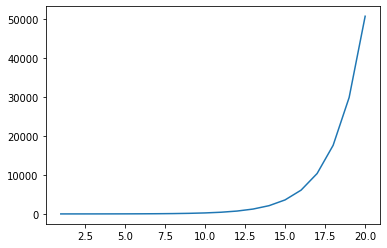

In [21]:
# 기울기 폭발 케이스 
dh = np.ones((N, H))
Wh = np.random.random((H, H))

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)           # (N, H)
    norm = np.sqrt(np.sum(dh**2)) / N  # 1, 1
    norm_list.append(norm)             # dh 크기 
    
    
plt.plot([i for i in range(1, T+1)], norm_list)
plt.show()

In [ ]:
# 기울기 폭발 해결: 기울기 클리핑
# 기울기 > threshold 이면 기울기 클리핑 

def grads_clip(grads, threshold):
    
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
        
    total_norm = np.sqrt(total_norm)  
    rate = threshold / (total_norm + 1e-6)
    
    if rate < 1:
        for grad in grads:
            grad = rate*grad
        

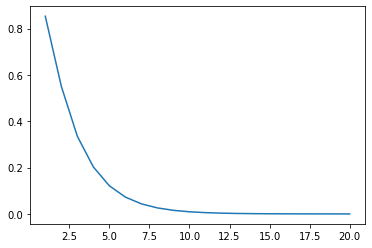

In [22]:
# 기울기 소실 케이스 
dh = np.ones((N, H))
Wh = np.random.random((H, H)) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)           # (N, H)
    norm = np.sqrt(np.sum(dh**2)) / N  # 1, 1
    norm_list.append(norm)             # dh 크기 
    
plt.plot([i for i in range(1, T+1)], norm_list)
plt.show()

In [ ]:
# 기울기 소실 해결: LSTM, GRU